In [1]:
import numpy as np
import sys
sys.path.insert(0, '../') 
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

# Loading Trained Networks

Loading the 10 weight matrices for each task

## Perception Task

In [2]:
weight_histories_perception = []
num_networks=10
for i in range(num_networks):
    print(i)
    with open('Perception_Task/relu/256_nodes/weight_history_{0}.json'.format(i)) as f:
        weight_history = json.load(f)
    weight_histories_perception.append(weight_history)

0
1
2
3
4
5
6
7
8
9


**Defining the 10 perception networks**

In [3]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_perception = []
perception_networks = []
for i in range(num_networks):
    weight_history = weight_histories_perception[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input_weights = np.array(weight_history['input weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][-1])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input_weights)))   
    input_weights_perception.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    perception_networks.append(network)

**Testing Networks**

In [4]:
time = 10000 #ms
def rule_input(time):
    #running for 5 seconds = 5000ms
    if time < 5000:
        return .5 + np.random.normal(0, .05)
    else:
        return .8 + np.random.normal(0, .05)
def target_func(time):
    #running for 5 seconds = 5000ms
    #Reverse of rule_input
    if time < 5000:
        return .8
    else:
        return .5
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)
def bias(time):
    return 1
input_funcs = [bias, noise, rule_input]
inputs = network.convert(time, input_funcs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1316.03it/s]


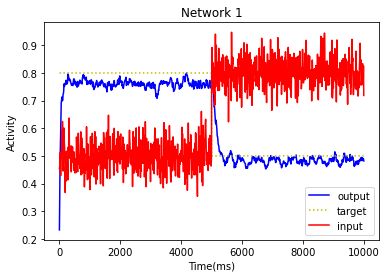

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1631.14it/s]


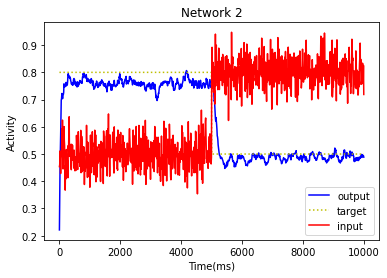

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1498.23it/s]


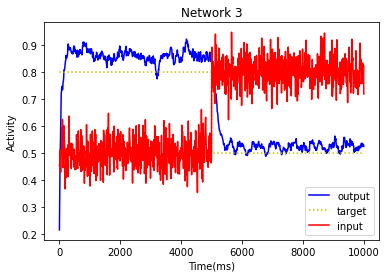

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1655.65it/s]


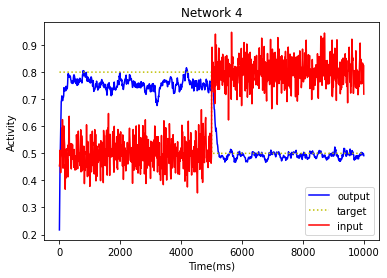

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1287.28it/s]


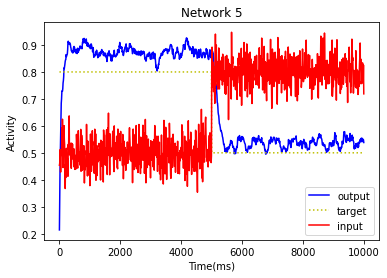

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1243.72it/s]


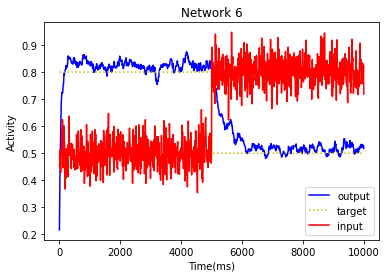

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1683.04it/s]


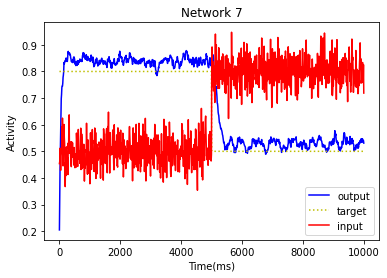

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1720.90it/s]


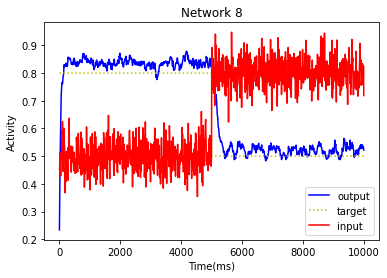

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1699.44it/s]


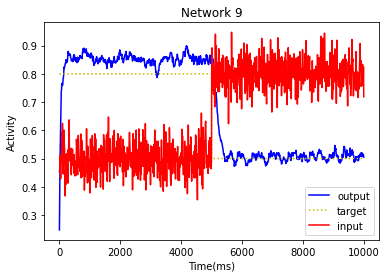

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1724.13it/s]


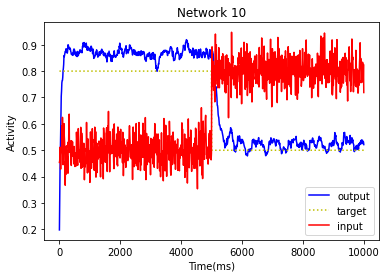

In [5]:
combined_outputs = []
for i, network in enumerate(perception_networks):
    network.reset_activations()
    outputs, activations = network.simulate(time, inputs, input_weights_perception[i])
    outputs = tf.transpose(outputs).numpy()[0]
    combined_outputs.append(outputs)
    fig, ax = plt.subplots()
    plt.plot(np.arange(0,timestep*len(outputs),timestep), outputs, 'b-', label='output')
    plt.plot(np.arange(0,timestep*len(outputs),timestep), [target_func(t * timestep) for t in range(len(outputs))], 'y:', label='target')
    plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,2], 'r-', label='input')
    plt.legend()
    plt.title('Network {0}'.format(i+1))
    plt.xlabel('Time(ms)')
    plt.ylabel('Activity')
    plt.show()

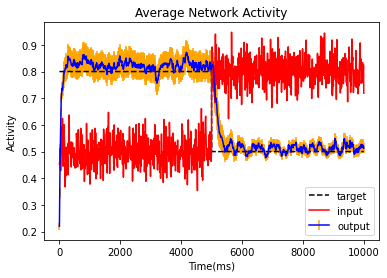

In [6]:
combined_out_mean = np.mean(combined_outputs, axis = 0)
combined_out_std = np.std(combined_outputs, axis = 0)

fig, ax = plt.subplots()
plt.errorbar(np.arange(0,timestep*len(outputs),timestep), combined_out_mean, yerr = combined_out_std, ecolor='orange', fmt='b-', label='output')
plt.plot(np.arange(0,timestep*len(outputs),timestep), [target_func(t * timestep) for t in range(len(outputs))], 'k--', label='target')
plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,2], 'r-', label='input')
plt.legend()
plt.title('Average Network Activity')
plt.xlabel('Time(ms)')
plt.ylabel('Activity')
plt.show()


## Decision Task

In [7]:
weight_histories_decision = []
for i in range(num_networks):
    print(i)
    with open('Decision_Task/relu/256_nodes/weight_history_{0}.json'.format(i)) as f:
        weight_history = json.load(f)
    weight_histories_decision.append(weight_history)

0
1
2
3
4
5
6
7
8
9


**Defining the 10 decision networks**

In [8]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01
input_weights_decision = []
decision_networks = []
for i in range(num_networks):
    weight_history = weight_histories_decision[i]
    noise_weights = np.array(weight_history['noise weights'])
    bias_weights = np.array(weight_history['bias'])
    input1_weights = np.array(weight_history['input1 weights'])
    input2_weights = np.array(weight_history['input2 weights'])
    output_weight_matrix = np.array(weight_history['output weights'])
    connectivity_matrix = np.array(weight_history['connectivity matrix'])
    final_weights = np.array(weight_history['trained weights'][-1])


    weight_matrix = tf.Variable(final_weights)
    connectivity_matrix = tf.constant(connectivity_matrix)

    input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input1_weights, input2_weights)))   
    input_weights_decision.append(input_weight_matrix)
    init_activations = tf.constant(np.zeros((num_nodes, 1)))
    output_weight_matrix = tf.constant(output_weight_matrix)

    network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
                 timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)
    decision_networks.append(network)

**Testing Networks**

In [9]:
time = 15000 #ms
switch_time = int(np.random.normal(time/2, time/10))

val1 = 0.2
val2 = 1.3
val3 = 1.5
val4 = 1.2

def input1(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return val1 + np.random.normal(0, .01)
    else:
        return val3 + np.random.normal(0, .01)

def input2(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return val2 + np.random.normal(0, .01)
    else:
        return val4 + np.random.normal(0, .01)
    
def target_func(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
    else:
        return 0.5 * (val3 > val4) + .8 * (val4 > val3)
    
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)
def bias(time):
    return 1

input_funcs = [bias, noise, input1, input2]
inputs = network.convert(time, input_funcs)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1640.88it/s]


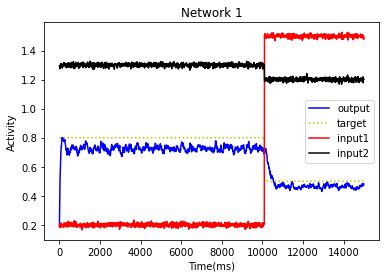

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1586.96it/s]


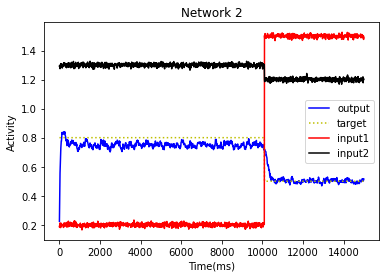

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1613.57it/s]


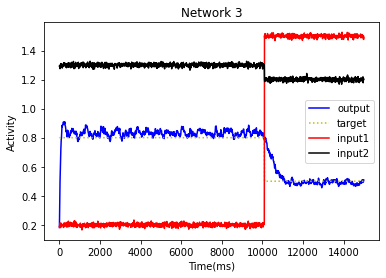

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1628.71it/s]


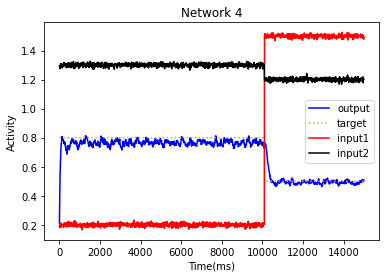

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1270.94it/s]


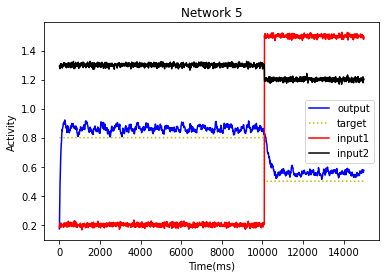

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1245.63it/s]


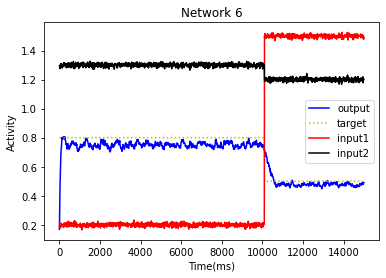

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1199.24it/s]


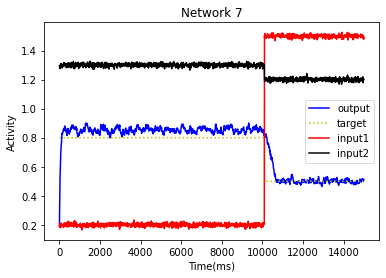

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1648.11it/s]


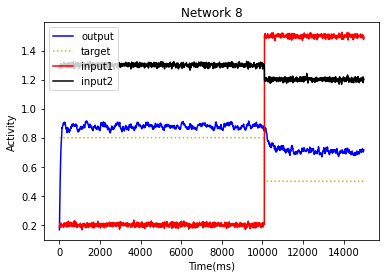

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1700.54it/s]


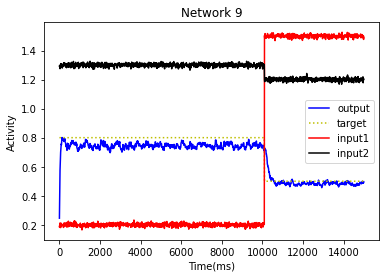

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1559.00it/s]


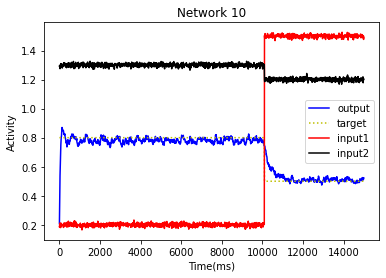

In [10]:
combined_outputs = []
for i, network in enumerate(decision_networks):
    network.reset_activations()
    outputs, activations = network.simulate(time, inputs, input_weights_decision[i])
    outputs = tf.transpose(outputs).numpy()[0]
    combined_outputs.append(outputs)
    fig, ax = plt.subplots()
    plt.plot(np.arange(0,timestep*len(outputs),timestep), outputs, 'b-', label='output')
    plt.plot(np.arange(0,timestep*len(outputs),timestep), [target_func(t * timestep) for t in range(len(outputs))], 'y:', label='target')
    plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,2], 'r-', label='input1')
    plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,3], 'k-', label='input2')
    plt.legend()
    plt.title('Network {0}'.format(i+1))
    plt.xlabel('Time(ms)')
    plt.ylabel('Activity')
    plt.show()

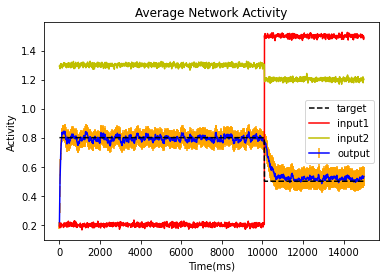

In [11]:
combined_out_mean = np.mean(combined_outputs, axis = 0)
combined_out_std = np.std(combined_outputs, axis = 0)

fig, ax = plt.subplots()
plt.plot(np.arange(0,timestep*len(outputs),timestep), [target_func(t * timestep) for t in range(len(outputs))], 'k--', label='target', zorder = 4)
plt.errorbar(np.arange(0,timestep*len(outputs),timestep), combined_out_mean, yerr = combined_out_std, ecolor='orange', fmt='b-', label='output', zorder=1)
plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,2], 'r-', label='input1',zorder=2)
plt.plot(np.arange(0,timestep*len(outputs),timestep), inputs[:,3], 'y-', label='input2',zorder=3)
plt.legend()
plt.title('Average Network Activity')
plt.xlabel('Time(ms)')
plt.ylabel('Activity')
plt.show()


# Analyzing Network Performance

## Perception Task

**Plotting average network activity for different inputs**

In [12]:
net_averages = []
for i, network in enumerate(perception_networks):
    print('Testing network {0}'.format(i), flush=True)
    averages = []
    inputs_arr = []
    for n in tqdm(np.arange(0, 20)):
        time = 10000
        inp = n * 0.05
        inputs_arr.append(inp)
        network.reset_activations()
        def rule_input(time):
            #running for 5 seconds = 5000ms
            return inp + np.random.normal(0, 0.05)
        
        input_funcs = [bias, noise, rule_input]
        inputs = network.convert(time, input_funcs)
        outputs, activations = network.simulate(time, inputs, input_weights_perception[i], disable_progress_bar = True)

        outputs = tf.transpose(outputs).numpy()[0]
        avg = np.mean(outputs)
        averages.append(avg)
    net_averages.append(averages)

Testing network 0


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.82it/s]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.80it/s]


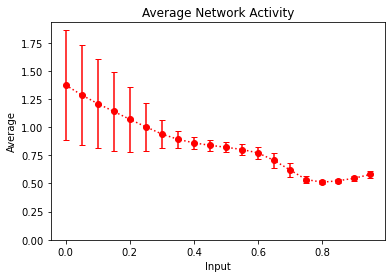

In [13]:
fig, ax = plt.subplots(1,1)
plt.errorbar(inputs_arr, np.mean(net_averages, axis=0), yerr = np.std(net_averages, axis=0), capsize=3, fmt = 'ro:')
plt.title('Average Network Activity')
plt.ylabel('Average')
plt.xlabel('Input')
plt.ylim(0)
plt.show()

## Decision Task

**Testing percentage correct classification for each difference at each location**

Only run the next few cells once, after running it will save the results to json.

In [15]:
net_percent_correct={}

**input2>input1**

In [16]:

locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)
num_trials = 10
time = 10000
percent_correct = {}
for location in locations:
    print('Testing location {0}'.format(location), flush=True)
    net_correct_per_diff = []
    for i, network in enumerate(decision_networks):
        print('Testing network {0}'.format(i), flush=True)
        correct_per_diff = []
        for diff in tqdm(differences, leave = True, position = 0):
            num_correct = []
            for trial in range(num_trials):
                network.reset_activations()
                val1 = location
                val2 = val1 + diff
                def input1(time):
                        return val1 + np.random.normal(0, .01)
                def input2(time):
                        return val2 + np.random.normal(0, .01)

                input_funcs = [bias, noise, input1, input2]
                inputs = network.convert(time, input_funcs)
                outputs, activations = network.simulate(time, inputs, input_weights_decision[i], disable_progress_bar = True)
                outputs = tf.transpose(outputs).numpy()[0]
                out = np.mean(outputs[100:])
                target = .8
                correct = 1*(out>.65)
                num_correct.append(correct)
            correct_per_diff.append(np.mean(num_correct)*100)
        net_correct_per_diff.append(correct_per_diff)
    percent_correct[location] = {}
    percent_correct[location]['vals']=np.mean(net_correct_per_diff, axis=0).tolist()
    percent_correct[location]['stds']=np.std(net_correct_per_diff, axis=0).tolist()

Testing location 0.25
Testing network 0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:53<00:00,  6.93s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:34<00:00,  6.18s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:28<00:00,  5.93s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:55<00:00,  7.03s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:31<00:00,  8.46s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:41<00:00,  8.88s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:31<00:00,  8.46s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:22<00:00,  8.11s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:08<00:00,  9.95s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:55<00:00,  9.42s/it]

Testing location 0.5
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:33<00:00, 10.94s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:59<00:00,  9.60s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:35<00:00,  8.63s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:13<00:00,  7.75s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:17<00:00,  7.88s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:29<00:00,  8.38s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:26<00:00,  8.26s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:31<00:00,  8.47s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:12<00:00,  7.71s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:38<00:00,  8.72s/it]

Testing location 0.75
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:20<00:00,  8.02s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:31<00:00,  8.47s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:24<00:00,  8.16s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:19<00:00,  7.99s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:37<00:00,  8.68s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:30<00:00,  8.42s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:52<00:00,  9.30s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:29<00:00,  8.40s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:51<00:00, 11.67s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:14<00:00, 10.19s/it]

Testing location 1.0
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:04<00:00,  9.80s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:06<00:00,  7.48s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:36<00:00,  8.67s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:34<00:00,  8.58s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:43<00:00, 13.73s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:21<00:00,  8.08s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:04<00:00,  7.36s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:11<00:00,  7.68s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:39<00:00,  6.37s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.30s/it]

Testing location 1.25
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.50s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.31s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:35<00:00,  6.21s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:33<00:00,  6.13s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:34<00:00,  6.17s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:35<00:00,  6.22s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.83s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.83s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:27<00:00,  5.89s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:36<00:00,  6.25s/it]

Testing location 1.5
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.82s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:23<00:00,  5.76s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:26<00:00,  5.84s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:32<00:00,  6.09s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.67s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:50<00:00,  9.23s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:07<00:00,  7.51s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:30<00:00,  8.43s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.61s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:14<00:00,  7.77s/it]

Testing location 1.75
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:19<00:00,  7.97s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:59<00:00,  7.20s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:07<00:00,  7.50s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:55<00:00,  7.01s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:12<00:00,  7.70s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:12<00:00,  7.68s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:00<00:00,  7.20s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.81s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:17<00:00,  7.91s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:55<00:00,  9.41s/it]


In [17]:
net_percent_correct['input2>input1']=percent_correct

**input1>input2**

In [18]:
locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)
num_trials = 10
time = 10000
percent_correct = {}
for location in locations:
    print('Testing location {0}'.format(location), flush=True)
    net_correct_per_diff = []
    for i, network in enumerate(decision_networks):
        print('Testing network {0}'.format(i), flush=True)
        correct_per_diff = []
        for diff in tqdm(differences, leave = True, position = 0):
            num_correct = []
            for trial in range(num_trials):
                network.reset_activations()
                val1 = location
                val2 = val1 - diff
                def input1(time):
                        return val1 + np.random.normal(0, .01)
                def input2(time):
                        return val2 + np.random.normal(0, .01)

                input_funcs = [bias, noise, input1, input2]
                inputs = network.convert(time, input_funcs)
                outputs, activations = network.simulate(time, inputs, input_weights_decision[i], disable_progress_bar = True)
                outputs = tf.transpose(outputs).numpy()[0]
                out = np.mean(outputs[100:])
                target = .5
                correct = 1*(out<.65)
                num_correct.append(correct)
            correct_per_diff.append(np.mean(num_correct)*100)
        net_correct_per_diff.append(correct_per_diff)
    percent_correct[location] = {}
    percent_correct[location]['vals']=np.mean(net_correct_per_diff, axis=0).tolist()
    percent_correct[location]['stds']=np.std(net_correct_per_diff, axis=0).tolist()

Testing location 0.25
Testing network 0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:36<00:00,  6.24s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:26<00:00,  5.86s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:24<00:00,  5.77s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:20<00:00,  5.64s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.97s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.81s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:23<00:00,  5.74s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.83s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.62s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:39<00:00,  6.37s/it]

Testing location 0.5
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:24<00:00,  5.80s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:21<00:00,  5.68s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.01s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:20<00:00,  5.64s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:24<00:00,  5.80s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:24<00:00,  5.76s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:23<00:00,  5.73s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:22<00:00,  5.70s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:29<00:00,  8.39s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.30s/it]

Testing location 0.75
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:36<00:00,  6.25s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.44s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.51s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:54<00:00,  6.97s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.57s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.64s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.00s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:33<00:00,  6.16s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.04s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.00s/it]

Testing location 1.0
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.83s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.98s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:28<00:00,  5.95s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:32<00:00,  6.12s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.96s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:20<00:00,  8.03s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:38<00:00, 18.35s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:45<00:00, 18.61s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:58<00:00, 19.14s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:01<00:00, 19.27s/it]

Testing location 1.25
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:53<00:00,  9.34s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:07<00:00, 17.09s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:55<00:00, 19.01s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:47<00:00, 18.72s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:00<00:00, 19.20s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:49<00:00, 21.18s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:24<00:00, 10.58s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:19<00:00,  7.99s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:37<00:00,  8.70s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:50<00:00,  9.22s/it]

Testing location 1.5
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:49<00:00,  9.20s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:04<00:00,  7.37s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:54<00:00,  6.99s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:56<00:00,  7.06s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:38<00:00,  8.73s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:30<00:00,  8.40s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:55<00:00,  7.03s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:04<00:00,  7.40s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:19<00:00, 10.37s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:38<00:00, 13.52s/it]

Testing location 1.75
Testing network 0



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:48<00:00,  9.12s/it]

Testing network 1



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.82s/it]

Testing network 2



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:03<00:00,  7.36s/it]

Testing network 3



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:04<00:00,  9.80s/it]

Testing network 4



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:44<00:00, 11.39s/it]

Testing network 5



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:22<00:00,  8.10s/it]

Testing network 6



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.63s/it]

Testing network 7



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.58s/it]

Testing network 8



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.58s/it]

Testing network 9



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.56s/it]


In [19]:
net_percent_correct['input1>input2']=percent_correct

In [20]:
with open('percentages_correct_decision.json', 'w') as f:
    json.dump(net_percent_correct, f)

Plotting results

In [21]:
with open('percentages_correct_decision.json') as f:
    percent_correct = json.load(f)

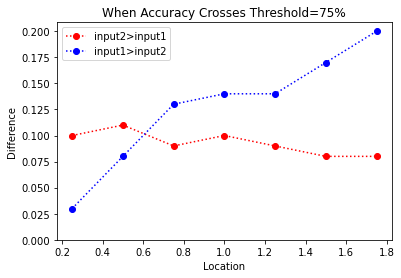

In [22]:
percent_correct1 = percent_correct['input2>input1']
percent_correct2 = percent_correct['input1>input2']
locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)

threshold = 75
greater_than_threshold1 = []
greater_than_threshold2= []
for location in locations:
    correct1 = percent_correct1[str(location)]['vals']
    correct2 = percent_correct2[str(location)]['vals']
    idx=differences.size
    for i, val in enumerate(correct1):
        if val >=threshold and i>0:
            idx=i
            break
    greater_than_threshold1.append(idx)
    
    idx=25
    for i, val in enumerate(correct2):
        if val >=threshold and i >0:
            idx=i
            break
    greater_than_threshold2.append(idx)
plotting_diff = np.append(differences, .5)
plt.plot(locations, [plotting_diff[g] for g in greater_than_threshold1], 'ro:', label='input2>input1')
plt.plot(locations, [plotting_diff[g] for g in greater_than_threshold2], 'bo:', label='input1>input2')
plt.title('When Accuracy Crosses Threshold=' + str(threshold) + '%')
plt.xlabel('Location')
plt.ylabel('Difference')
plt.ylim(0)
plt.legend()
plt.show()